In [2]:
import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvP4M

In [3]:

# Construct G-Conv layers
C1 = P4MConvP4M(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=1)

# Create 10 images with 1 channels and 32x32 pixels:
img = torch.ones([10, 8, 32, 3])
x = Variable(img)

# fprop
y = C1(x)
print(y.data.shape)

torch.Size([10, 1, 8, 30, 1])


In [4]:
import numpy as np
import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv.splitgconv2d import P4ConvZ2, P4ConvP4, P4MConvZ2, P4MConvP4M

In [5]:
import torch.nn.functional as F


def plane_group_spatial_max_pooling(x, ksize, stride=None, pad=0):
    xs = x.size()
    x = x.view(xs[0], xs[1] * xs[2], xs[3], xs[4])
    x = F.max_pool2d(input=x, kernel_size=ksize, stride=stride, padding=pad)
    x = x.view(xs[0], xs[1], xs[2], x.size()[2], x.size()[3])
    return x

In [6]:
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch
import math
from torch.nn.modules.utils import _pair
from groupy.gconv.make_gconv_indices import *

make_indices_functions = {(1, 4): make_c4_z2_indices,
                          (4, 4): make_c4_p4_indices,
                          (1, 8): make_d4_z2_indices,
                          (8, 8): make_d4_p4m_indices}


def trans_filter(w, inds):
    inds_reshape = inds.reshape((-1, inds.shape[-1])).astype(np.int64)
    w_indexed = w[:, :, inds_reshape[:, 0].tolist(), inds_reshape[:, 1].tolist(), inds_reshape[:, 2].tolist()]
    w_indexed = w_indexed.view(w_indexed.size()[0], w_indexed.size()[1],
                                    inds.shape[0], inds.shape[1], inds.shape[2], inds.shape[3])
    w_transformed = w_indexed.permute(0, 2, 1, 3, 4, 5)
    return w_transformed.contiguous()


class SplitGConv2D(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=True, input_stabilizer_size=1, output_stabilizer_size=4):
        super(SplitGConv2D, self).__init__()
        assert (input_stabilizer_size, output_stabilizer_size) in make_indices_functions.keys()
        self.ksize = kernel_size

        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.input_stabilizer_size = input_stabilizer_size
        self.output_stabilizer_size = output_stabilizer_size

        self.weight = Parameter(torch.Tensor(
            out_channels, in_channels, self.input_stabilizer_size, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

        self.inds = self.make_transformation_indices()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def make_transformation_indices(self):
        return make_indices_functions[(self.input_stabilizer_size, self.output_stabilizer_size)](self.ksize)

    def forward(self, input):
        tw = trans_filter(self.weight, self.inds)
        tw_shape = (self.out_channels * self.output_stabilizer_size,
                    self.in_channels * self.input_stabilizer_size,
                    self.ksize, self.ksize)
        tw = tw.view(tw_shape)

        input_shape = input.size()
        input = input.view(input_shape[0], self.in_channels*self.input_stabilizer_size, input_shape[-2], input_shape[-1])

        y = F.conv2d(input, weight=tw, bias=None, stride=self.stride,
                        padding=self.padding)
        batch_size, _, ny_out, nx_out = y.size()
        y = y.view(batch_size, self.out_channels, self.output_stabilizer_size, ny_out, nx_out)

        if self.bias is not None:
            bias = self.bias.view(1, self.out_channels, 1, 1, 1)
            y = y + bias

        return y


class P4ConvZ2(SplitGConv2D):

    def __init__(self, *args, **kwargs):
        super(P4ConvZ2, self).__init__(input_stabilizer_size=1, output_stabilizer_size=4, *args, **kwargs)


class P4ConvP4(SplitGConv2D):

    def __init__(self, *args, **kwargs):
        super(P4ConvP4, self).__init__(input_stabilizer_size=4, output_stabilizer_size=4, *args, **kwargs)


class P4MConvZ2(SplitGConv2D):

    def __init__(self, *args, **kwargs):
        super(P4MConvZ2, self).__init__(input_stabilizer_size=1, output_stabilizer_size=8, *args, **kwargs)


class P4MConvP4M(SplitGConv2D):

    def __init__(self, *args, **kwargs):
        super(P4MConvP4M, self).__init__(input_stabilizer_size=8, output_stabilizer_size=8, *args, **kwargs) 

In [7]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [8]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [9]:
dataset = torchvision.datasets.MNIST(
    root = 'data',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
)

In [10]:
from torch.utils.data import Dataset
from torchvision import datasets

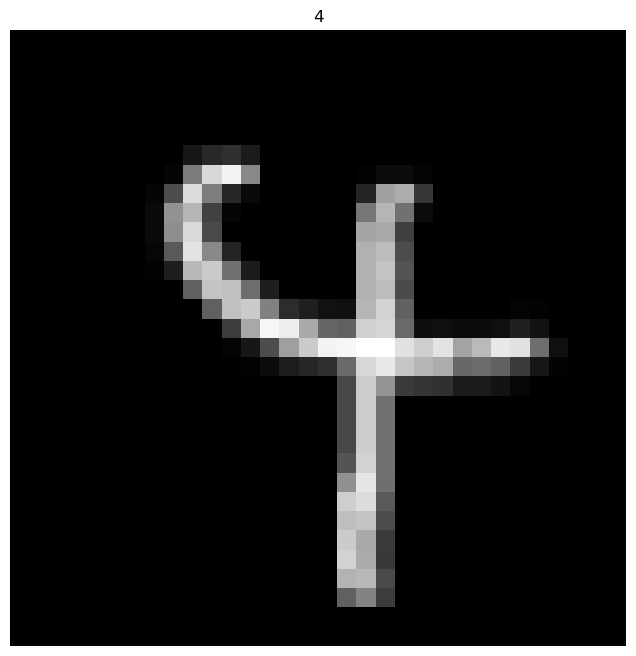

In [11]:
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.mnist import MNIST
import warnings
from PIL import Image
import os
import os.path
import numpy as np
import torch
import codecs
import string
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
import shutil
import torchvision.datasets.mnist as mts

import random

class RotMNIST(VisionDataset):
    """`RotMNIST`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``RotMNIST/processed/training.pt``
            and  ``RotMNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    mirrors = [
        'http://yann.lecun.com/exdb/mnist/',
        'https://ossci-datasets.s3.amazonaws.com/mnist/',
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(RotMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train  # training set or test set

        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()
            return

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        self.data, self.targets = self._load_data()

    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False

        return all(
            check_integrity(os.path.join(self.processed_folder, file)) for file in (self.training_file, self.test_file)
        )

    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))

    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data =  mts.read_image_file(os.path.join(self.raw_folder, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        targets = mts.read_label_file(os.path.join(self.raw_folder, label_file))

        return data, targets

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        # Preform random rotation and mirroring for img
        # Preform flip
        img = torch.flip(img, [random.randint(-1, 1)])

        # Preform random rotation (90 increments)
        # img = torch.rot90(img, random.randint(-1, 2), [-1, 1])

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self) -> Dict[str, int]:
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = "{}{}".format(mirror, filename)
                try:
                    print("Downloading {}".format(url))
                    download_and_extract_archive(
                        url, download_root=self.raw_folder,
                        filename=filename,
                        md5=md5
                    )
                except URLError as error:
                    print(
                        "Failed to download (trying next):\n{}".format(error)
                    )
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError("Error downloading {}".format(filename))

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")


C:\Users\Jack\anaconda3\envs\reu-code\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


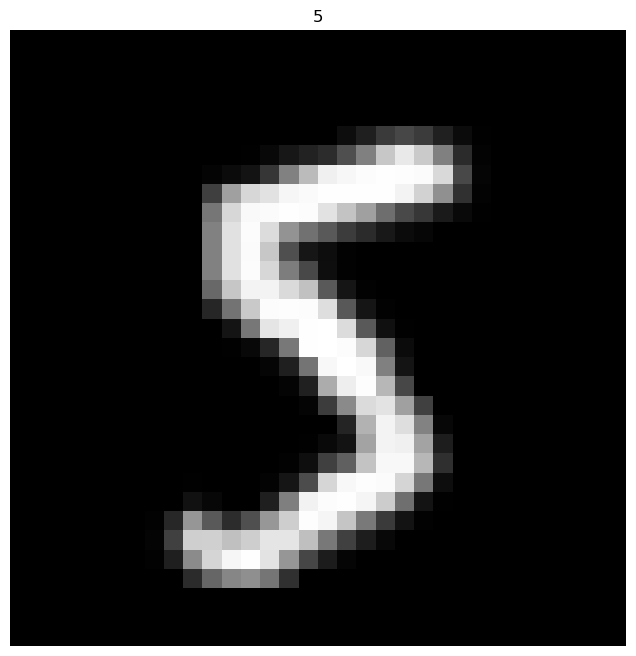

In [13]:
rot_dataset = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
)
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(rot_dataset), size=(1,)).item()
img, label = dataset[sample_idx]
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# flip_int = [random.randint(0, 1)]
# flip_int2 = [random.randint(-1, 0)]
# img = torch.flip(img, flip_int)
# img = torch.flip(img, flip_int2)
# print(flip_int)
# print(flip_int2)
# plt.title(label)
# plt.axis("off")
# plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

Feature batch shape: torch.Size([64, 1, 32, 32])
Labels batch shape: torch.Size([64])


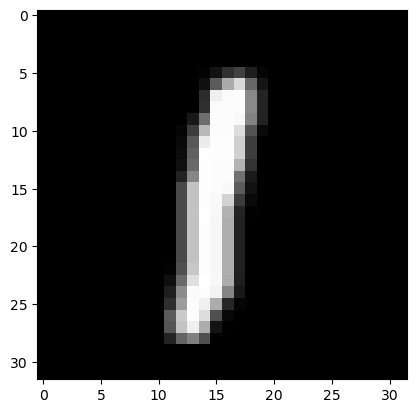

Label: 1


In [114]:
train_dataloader = DataLoader(rot_dataset, batch_size=1, shuffle=True)
is_seven = False
while not is_seven:
    train_features, train_labels = next(iter(train_dataloader))
    train_labels[0].type
    is_seven = True
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = C1
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()